# Chapter 4 - Classification

- [Load dataset](#Load-dataset)
- [The Default data set](#Figure-4.1---Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
- [Lab: 4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
- [Lab: 4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
- [Lab: 4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
- [Lab: 4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load dataset

In [2]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
# df = pd.read_excel('Data/Default.xlsx')
df = pd.read_excel('https://github.com/borisgarbuzov/schulich_data_science_1/blob/master/Data/Default.xlsx?raw=true')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object.
# what is factorize?
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0


###  Figure 4.1 - Default data set

In [3]:
# B
# Experiments with the code below
myList = ["a", "b", "c", "d"]
print(myList[0:-2])
print(myList[:-2])
mySeries = pd.Series(myList)
sample1 = mySeries.sample()
print("type(sample1) =", type(sample1))
print("sample1 =", sample1)
# By default, sample size = 1
sample2 = mySeries.sample(frac = 0.5)
print("sample2 =\n", sample2)
print("type(sample2) =", type(sample2))
sample3 = mySeries.sample(n = 3)
print("sample3 =\n", sample3)
sample4 = mySeries.sample(n = 4)
print("sample4 =\n", sample4)
# sample5 = mySeries.sample(n = 5)
# print("sample5 =\n", sample5)

['a', 'b']
['a', 'b']
type(sample1) = <class 'pandas.core.series.Series'>
sample1 = 1    b
dtype: object
sample2 =
 2    c
0    a
dtype: object
type(sample2) = <class 'pandas.core.series.Series'>
sample3 =
 2    c
3    d
0    a
dtype: object
sample4 =
 1    b
3    d
0    a
2    c
dtype: object


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


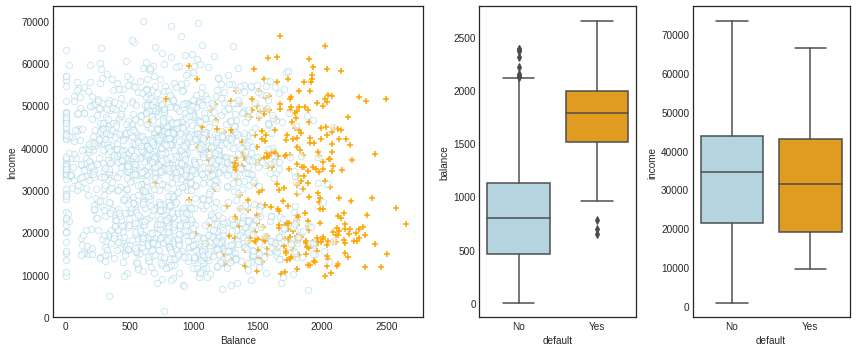

In [4]:
fig = plt.figure(figsize=(12,5))
# diviede the figure splace to 1 line and 4 columns
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])
# There are less defaults than non-defaults.
# That is why we need 15%? 
# Take a fraction of the samples where target value (default) is 'no'
# Perhaps, because we have more no than yes
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
# Collects all graphs (axes) from the GridSpec
gs.tight_layout(plt.gcf())
# Without the command above, labels may run onto one another. 

plt.show()

## 4.3 Logistic Regression
### Figure 4.2

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


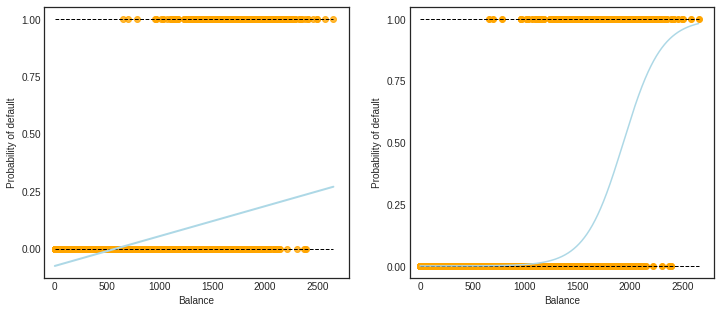

In [5]:
# B: May work both .to_numpy() and .values
# Each element we wrap up into the square brackets
X_train = df.balance.values.reshape(-1,1) 

y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)


clf = skl_lm.LogisticRegression(solver='newton-cg')
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn-linear-model-logisticregression
# Description of Newton-cg and other solvers
# https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Visually, this line should be steeper. 

# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100, xmax=2800)
    
plt.show()

### Table 4.1

In [6]:

y = df.default2

#####  scikit-learn

In [7]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)

print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65132973]


##### statsmodels
When we did it by sci-kit learn, we did not need to add a constant. 
Now we need it. 

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

###  Table 4.2

In [9]:
X_train = sm.add_constant(df.student2)
y = df.default2

# est = smf.logit(y, X_train).fit()
est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320



###  Table 4.3 - Multiple Logistic Regression

In [10]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = sm.Logit(y, X_train).fit()
# https://tedboy.github.io/statsmodels_doc/generated/generated/statsmodels.api.Logit.html
# est = smf.logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


In [11]:
X_train.head() 

,const,balance,income,student2
0,1.0,729.526495,44361.625074,0
1,1.0,817.180407,12106.134700,1
2,1.0,1073.549164,31767.138947,0
3,1.0,529.250605,35704.493935,0
4,1.0,785.655883,38463.495879,0


### Figure 4.3 - Confounding

In [12]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba

In [13]:
df.groupby(['student','default']).size().unstack('default') # S default=-1

default,No,Yes
student,,
No,6850,206
Yes,2817,127


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


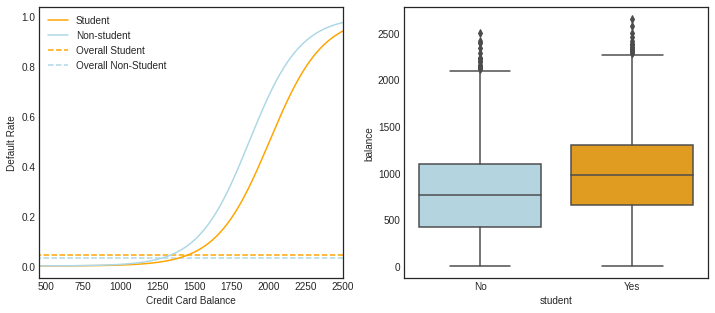

In [14]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))



# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette)
plt.show()

## 4.4 Linear Discriminant Analysis
### Table 4.4 


In [15]:
# X = df[['balance', 'income', 'student2']].as_matrix()
X = df[['balance', 'income', 'student2']].to_numpy()


y = df.default2.to_numpy()

lda = LinearDiscriminantAnalysis(solver='svd')
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [16]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [17]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9435,140
Yes,232,193


#  Lab

### 4.6.3 Linear Discriminant Analysis

In [18]:

# df = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
df

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...
2005-01-01,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
2005-01-01,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
2005-01-01,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up


In [19]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

In [20]:
lda.priors_

array([0.49198397, 0.50801603])

In [21]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [22]:
# These do not seem to correspond to the values from the R output in the book?
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [23]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]])

In [24]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



In [25]:
pred_p = lda.predict_proba(X_test)


In [26]:
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True]), array([ 70, 182]))

In [27]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False]), array([252]))

### 4.6.4 Quadratic Discriminant Analysis

In [28]:
qda = QuadraticDiscriminantAnalysis()
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html
pred = qda.fit(X_train, y_train).predict(X_test)


In [29]:
qda.priors_

array([0.49198397, 0.50801603])

In [30]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [31]:
confusion_matrix(y_test, pred).T

array([[ 30,  20],
       [ 81, 121]])

In [32]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252



### 4.6.5 K-Nearest Neighbors

In [33]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

[[43 68]
 [58 83]]
              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



In [34]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

[[48 63]
 [55 86]]
              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



### 4.6.6 An Application to Caravan Insurance Data

#### K-Nearest Neighbors

In [35]:
# In R, I exported the dataset from package 'ISLR' to a csv file
# df = pd.read_csv('Data/Caravan.csv')
df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Caravan.csv')
df

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
2,3,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
3,4,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
4,5,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,5818,36,1,1,2,8,0,6,1,2,1,2,6,5,3,2,2,5,2,2,0,0,4,1,3,2,3,3,3,0,9,0,5,1,3,5,4,4,3,3,...,6,0,4,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,No
5818,5819,35,1,4,4,8,1,4,1,4,6,0,3,2,2,5,0,0,9,2,1,1,3,3,2,0,4,5,0,0,3,6,6,1,2,6,3,0,9,0,...,0,0,0,0,1,0,0,3,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,No
5819,5820,33,1,3,4,8,0,6,0,3,5,1,4,3,3,4,0,1,8,1,0,0,2,3,5,1,1,1,4,4,7,2,4,0,5,8,1,5,3,1,...,6,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Yes
5820,5821,34,1,3,2,8,0,7,0,2,7,2,0,0,4,5,0,2,7,0,2,0,2,4,2,0,0,4,5,0,2,7,5,4,0,9,0,0,5,4,...,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No


In [36]:
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

def KNN(n_neighbors=1, weights='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return(pred, score, clf.classes_)

def plot_confusion_matrix(cm, classes, n_neighbors, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix: KNN-{}'.format(n_neighbors))
    plt.colorbar()
    plt.xticks(np.arange(2), classes)
    plt.yticks(np.arange(2), classes)
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

cm_normalized =
 [[0.93730074 0.06269926]
 [0.81355932 0.18644068]]


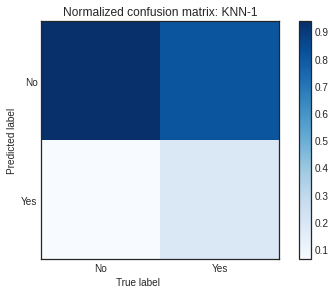

True        No  Yes
Predicted          
No         882   48
Yes         59   11
     Precision
No    0.948387
Yes   0.157143
cm_normalized =
 [[0.97874601 0.02125399]
 [0.89830508 0.10169492]]


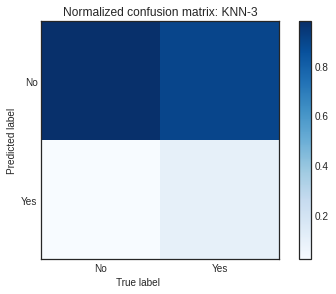

True        No  Yes
Predicted          
No         921   53
Yes         20    6
     Precision
No    0.945585
Yes   0.230769
cm_normalized =
 [[0.99256111 0.00743889]
 [0.93220339 0.06779661]]


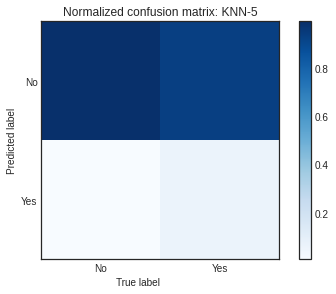

True        No  Yes
Predicted          
No         934   55
Yes          7    4
     Precision
No    0.944388
Yes   0.363636


In [37]:
for i in [1,3,5]:
    pred, score, classes = KNN(i)
    cm = confusion_matrix(y_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #-----stopped here--------
    print("cm_normalized =\n", cm_normalized)
    plot_confusion_matrix(cm_normalized.T, classes, n_neighbors=i)
    cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)    
    print(pd.DataFrame(precision_score(y_test, pred, average=None),
                       index=classes, columns=['Precision']))        

####  Logistic Regression

In [38]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
pred = regr.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

True        No  Yes
Predicted          
No         935   59
Yes          6    0
              precision    recall  f1-score   support

          No       0.94      0.99      0.97       941
         Yes       0.00      0.00      0.00        59

    accuracy                           0.94      1000
   macro avg       0.47      0.50      0.48      1000
weighted avg       0.89      0.94      0.91      1000



In [40]:
pred_p = regr.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_test, cm_df.Pred))

Pred   No  Yes
True          
No    918   23
Yes    48   11
              precision    recall  f1-score   support

          No       0.95      0.98      0.96       941
         Yes       0.32      0.19      0.24        59

    accuracy                           0.93      1000
   macro avg       0.64      0.58      0.60      1000
weighted avg       0.91      0.93      0.92      1000

